In [228]:
# import scipy.io
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import geopy.point as point
from tools import *
from scipy.spatial import distance

In [2]:
location = 'london_square'
base = f'../Simulation/dataset/{location}_cell.mat'
# base = f'../Simulation/dataset/data_with_building/{location}_cell.mat'
meta_data_ld, cir_profile_ld, dist_ld, TX_ld, RX_ld = read_mat(base, location)

In [3]:
max_len = 5 # max number of reflections in a ray trace

# initiate an extractor
ext_ld = Extractor(cir_profile_ld)
# formatting CIR profiles
X_ld = ext_ld.formatting_X(max_len=max_len)

d:\Telecom_2eme_anne\Geolocation_simulation\Polished_code\tools.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
  self.mag = - math.floor(math.log(np.mean(self.delay_set), 10))
d:\Telecom_2eme_anne\Geolocation_simulation\Polished_code\tools.py:176: ComplexWarning: Casting complex values to real discards the imaginary part
  cir_t.append(np.array(cir_shaped, dtype='float'))


In [4]:
def noise_gen(x, snr=20):
    n = len(x)
    noise = np.random.randn(n)
    signal_power = np.sum(x*x) / n
    noise_power = np.sum(noise * noise) / n
    noise_var = signal_power / (10 ** (snr/10))
    noise_gaussian = np.sqrt(noise_var / noise_power) * noise
    return x + noise_gaussian

In [5]:
T, S = cir_profile_ld.shape
cir_noise = []
noise_amp = []
cir_normal = []

x_pre = []
for j in range(T):
    cir_t = [] # channel impulse response for a transmitter
    for i in range(S):
        c_tmp = cir_profile_ld[j, i].copy()
        c_tmp[0, :] = c_tmp[0, :] * 10 ** 7 # normalize the delay seconds
        
        m, n = c_tmp.shape
        if m == 2:
            c_tmp[1, :] = abs(c_tmp[1, :])

        c_tmp_noise = c_tmp.copy()
        n = len(c_tmp[1, :])
        seq = np.pad(c_tmp[1, :], (0, 5-n), 'constant', constant_values=0)
        c_tmp_noise = noise_gen(seq, 5)
        cir_normal.append(seq)
        
        # noise_amp.append(c_tmp_noise[1, :])
        cir_noise.append(c_tmp_noise)

In [7]:
_, cir_noise_10 = cir_gen(snr=10)

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\numpy\lib\histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\transforms.py:1969: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


(array([1091., 2590., 3081., 3753., 3188., 2930., 2235., 1129.,  322.,
          50.]),
 array([9.50657671e-08+0.j, 5.32983879e-07+0.j, 9.70901992e-07+0.j,
        1.40882010e-06+0.j, 1.84673822e-06+0.j, 2.28465633e-06+0.j,
        2.72257444e-06+0.j, 3.16049255e-06+0.j, 3.59841067e-06+0.j,
        4.03632878e-06+0.j, 4.47424689e-06+0.j]),
 <a list of 10 Patch objects>)

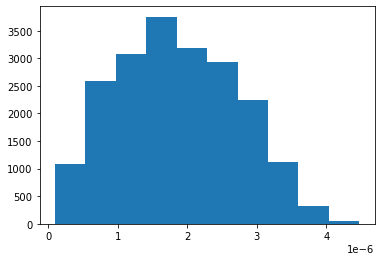

In [5]:
plt.hist(ext_ld.delay_set)

In [6]:
tau, amp = cir_profile_ld[0][0]

In [139]:
max(ext_ld.delay_set)

(4.474246889599328e-06+0j)

### Channel estimation


In [7]:
t_max = max(ext_ld.delay_set)

In [276]:
fc = 1e9
W = 1e6

In [277]:
x = np.linspace(0,t_max, int(fc * t_max)+1)
sinc_t = np.sinc(W * x)

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


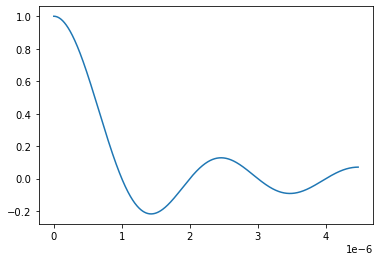

In [278]:
plt.plot(x, sinc_t)

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: UserWarning: In Matplotlib 3.3 individual lines on a stem pl

<StemContainer object of 3 artists>

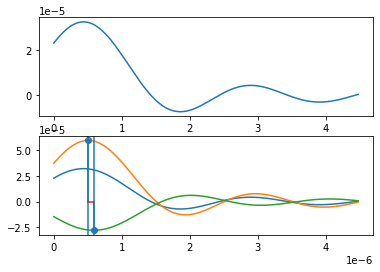

In [303]:
# tau, amp = cir_profile_ld[j, i].copy()
ans = np.repeat(x[:, None], len(tau), axis=1) - tau
y = np.sinc(W * ans) @ amp

_, axs = plt.subplots(2, 1)
axs[0].plot(x, y)
axs[1].plot(x, y)
axs[1].plot(x, amp[0] * np.sinc(W * (x-tau[0])))
axs[1].plot(x, amp[1] * np.sinc(W * (x-tau[1])))
axs[1].axvline(tau[0])
axs[1].axvline(tau[1])
axs[1].stem(tau, amp)

In [279]:
T, S = cir_profile_ld.shape
cir_noise = []
cir_pure = []
snr = 40

x_pre = []
for j in range(T):
    cir_t = [] # channel impulse response for a transmitter
    for i in range(S):
        tau, amp = cir_profile_ld[j, i].copy()
        ans = np.repeat(x[:, None], len(tau), axis=1) - tau
        y = np.sinc(W * ans) @ amp
        # c_tmp_noise = noise_gen(y, snr)
        n = len(y)
        noise = np.random.randn(n, 2).view(np.complex128)
        signal_power = np.sum(y * y) / n
        signal_db = 10 * np.log10(signal_power)
        noise_power = np.sum(noise * noise) / n
        noise_var = signal_power / (10 ** (snr/10))
        # noise_var = 10 ** ((signal_db - snr) / 10)
        # # print(noise_var)
        noise_gaussian = np.sqrt(noise_var / noise_power) * noise
        # noise_gaussian = np.random.normal(0, np.sqrt(noise_var), n).view(np.complex128)
        x_n = y + np.squeeze(noise_gaussian)
        cir_noise.append(x_n)
        cir_pure.append(y)

In [203]:
T, S = cir_profile_ld.shape
cir_full_noise = []
snr = 40

x_pre = []
for j in range(T):
    cir_t = [] # channel impulse response for a transmitter
    for i in range(S):
        tau, amp = cir_profile_ld[j, i].copy()
        tau_noise = np.random.normal(np.real(tau), .05 * np.real(tau))
        ans = np.repeat(x[:, None], len(tau), axis=1) - tau_noise
        y = np.sinc(W * ans) @ amp
        # c_tmp_noise = noise_gen(y, snr)
        n = len(y)
        noise = np.random.randn(n, 2).view(np.complex128)
        signal_power = np.sum(y * y) / n
        signal_db = 10 * np.log10(signal_power)
        noise_power = np.sum(noise * noise) / n
        noise_var = signal_power / (10 ** (snr/10))
        # noise_var = 10 ** ((signal_db - snr) / 10)
        # # print(noise_var)
        noise_gaussian = np.sqrt(noise_var / noise_power) * noise
        # noise_gaussian = np.random.normal(0, np.sqrt(noise_var), n).view(np.complex128)
        x_n = y + np.squeeze(noise_gaussian)
        cir_full_noise.append(x_n)


In [287]:
tau, amp

(array([5.06187877e-07+0.j, 5.86357547e-07+0.j]),
 array([ 5.98175696e-05+1.45384459e-04j, -2.81243185e-05+4.18413002e-05j]))

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


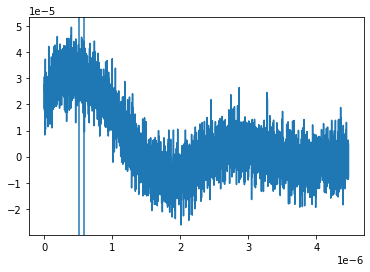

In [291]:
n = len(y)
noise = np.random.randn(n, 2).view(np.complex128)
signal_power = np.sum(y * y) / n
signal_db = 10 * np.log10(signal_power)
noise_power = np.sum(noise * noise) / n
noise_var = signal_power / (10 ** (40/10))
# noise_var = 10 ** ((signal_db - snr) / 10)
# # print(noise_var)
noise_gaussian = np.sqrt(noise_var / noise_power) * noise
# noise_gaussian = np.random.normal(0, np.sqrt(noise_var), n).view(np.complex128)
x_n = y + np.squeeze(noise_gaussian)

plt.plot(x, x_n)
plt.axvline(tau[0])
plt.axvline(tau[1])

In [281]:
cirs_noise = np.array(cir_noise)
cirs_pure = np.array(cir_pure)
cirs_full_noise = np.array(cir_full_noise)
m = len(cirs_noise)

In [304]:
cirs_noise.shape

(10000, 4475)

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values t

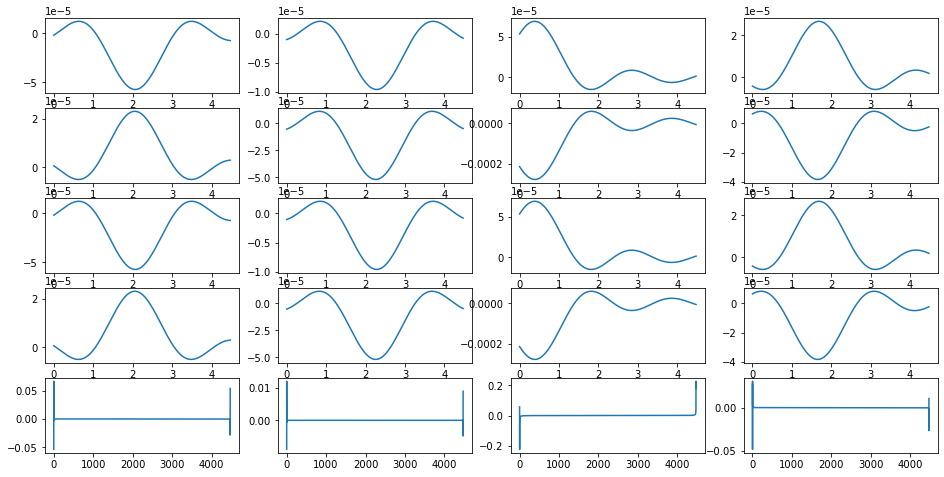

In [282]:
idx = np.random.choice(m, 4)
fig, axs = plt.subplots(5, len(idx), figsize=(16,8))
for ax, id in zip(axs[0], idx):
    ax.plot(x, np.real(cirs_noise[id, :]))

for ax, id in zip(axs[1], idx):
    ax.plot(x, np.imag(cirs_noise[id, :]))

for ax, id in zip(axs[2], idx):
    ax.plot(x, np.real(cirs_pure[id, :]))

for ax, id in zip(axs[3], idx):
    ax.plot(x, np.imag(cirs_pure[id, :]))   

for ax, id in zip(axs[4], idx):
    ax.plot(np.fft.fft(cirs_noise[id, :]))

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values t

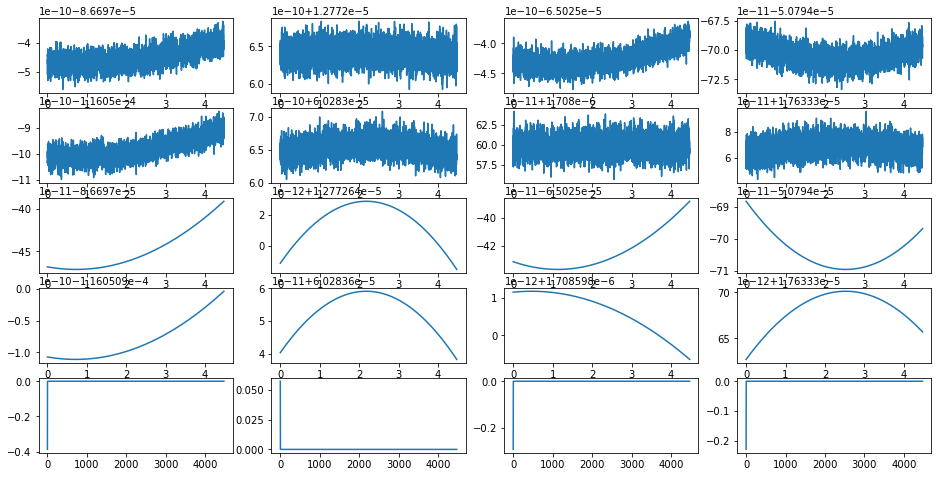

In [213]:
idx = np.random.choice(m, 4)
fig, axs = plt.subplots(5, len(idx), figsize=(16,8))
for ax, id in zip(axs[0], idx):
    ax.plot(x, np.real(cirs_full_noise[id, :]))

for ax, id in zip(axs[1], idx):
    ax.plot(x, np.imag(cirs_full_noise[id, :]))

for ax, id in zip(axs[2], idx):
    ax.plot(x, np.real(cirs_pure[id, :]))

for ax, id in zip(axs[3], idx):
    ax.plot(x, np.imag(cirs_pure[id, :]))   

for ax, id in zip(axs[4], idx):
    ax.plot(np.fft.fft(cirs_noise[id, :]))

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection

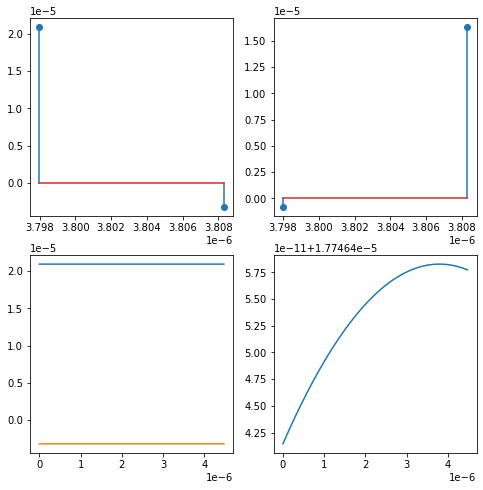

In [229]:
fig, axs = plt.subplots(2,2, figsize=(8,8))
t, s = np.random.choice(T), np.random.choice(S)
# t,s = 397, 7
tau, amp = cir_profile_ld[t, s]
axs[0, 0].stem(tau, np.real(amp))
axs[0, 1].stem(tau, np.imag(amp))
axs[1, 0].plot(x, amp[0] * np.sinc(W * (x-tau[0])))
axs[1, 0].plot(x, amp[1] * np.sinc(W * (x-tau[1])))
axs[1, 1].plot(x, amp[0] * np.sinc(W * (x-tau[0])) + amp[1] * np.sinc(W * (x-tau[1])))
# axs[1,0].set_yscale('log')

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


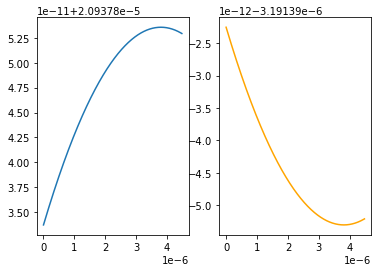

In [233]:
_, axs = plt.subplots(1,2)
axs[ 0].plot(x, amp[0] * np.sinc(W * (x-tau[0])))
axs[1].plot(x, amp[1] * np.sinc(W * (x-tau[1])), c='orange')

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
d:\Users

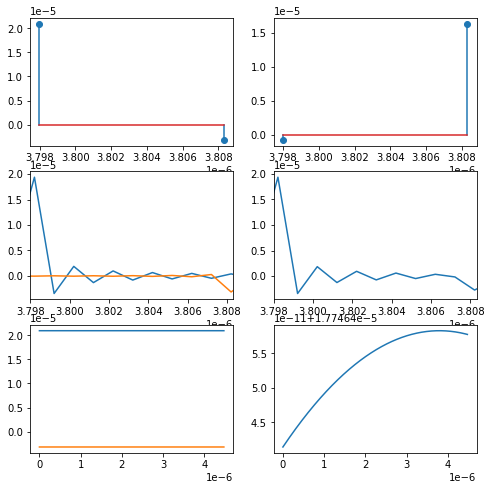

In [232]:
fig, axs = plt.subplots(3,2, figsize=(8,8))
# t, s = np.random.choice(T), np.random.choice(S)
# t,s = 397, 7
tau, amp = cir_profile_ld[t, s]
axs[0, 0].stem(tau, np.real(amp))
axs[0, 1].stem(tau, np.imag(amp))
axs[1, 0].plot(x, amp[0] * np.sinc(fc * (x-tau[0])))
axs[1, 0].plot(x, amp[1] * np.sinc(fc * (x-tau[1])))
axs[1,0].set_xlim(tau)

axs[1, 1].plot(x, amp[0] * np.sinc(fc * (x-tau[0])) + amp[1] * np.sinc(fc * (x-tau[1])))
axs[1,1].set_xlim(tau)


axs[2, 0].plot(x, amp[0] * np.sinc(W * (x-tau[0])))
axs[2, 0].plot(x, amp[1] * np.sinc(W * (x-tau[1])))
# axs[2,0].set_xlim(tau)

axs[2, 1].plot(x, amp[0] * np.sinc(W * (x-tau[0])) + amp[1] * np.sinc(W * (x-tau[1])))
# axs[2,1].set_xlim(tau)


### data preparation

In [163]:
cirs_noise_shaped = cirs_noise.reshape(T, -1)
cirs_full_noise_shaped = cirs_full_noise.reshape(T, -1)

In [171]:
4475 * 25, cirs_noise_shaped.shape

(111875, (400, 111875))

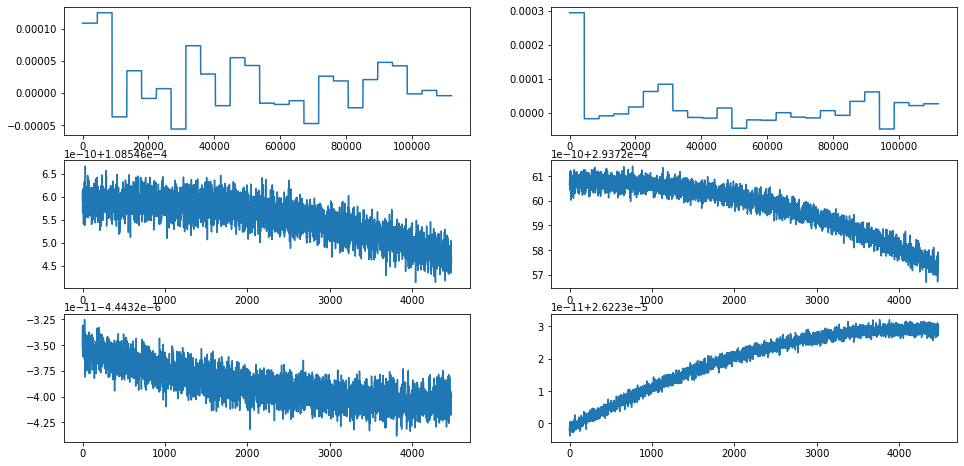

In [192]:
fig, axs = plt.subplots(3,2, figsize=(16,8))

axs[0, 0].plot(np.real(cirs_noise_shaped[0]))
axs[1, 0].plot(np.real(cirs_noise_shaped[0, 0:len(x)]))
axs[2, 0].plot(np.real(cirs_noise_shaped[0, -len(x):]))

axs[0, 1].plot(np.imag(cirs_noise_shaped[0]))
axs[1, 1].plot(np.imag(cirs_noise_shaped[0, 0:len(x)]))
axs[2, 1].plot(np.imag(cirs_noise_shaped[0, -len(x):]))

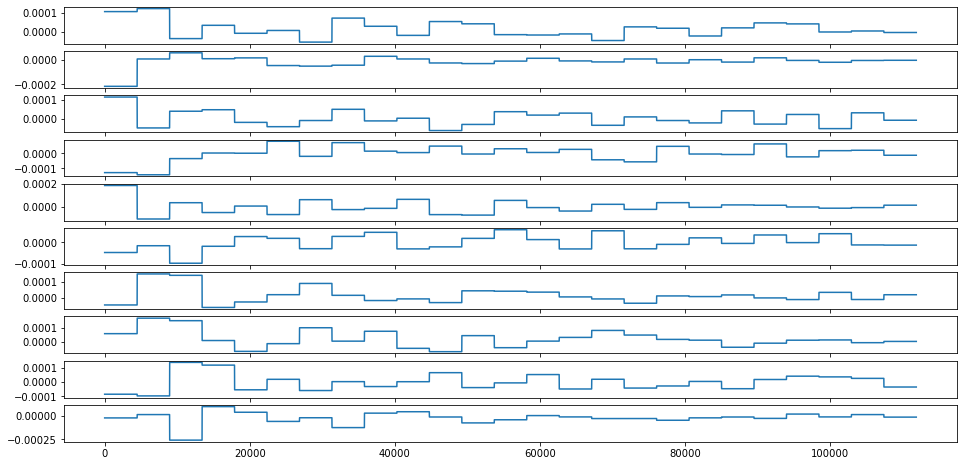

In [190]:
fig, axs = plt.subplots(10, 1, figsize=(16,8))
idx = np.arange(10)
for i in range(10):
    axs[i].plot(np.real(cirs_noise_shaped[i]))
# axs[0, 0].plot(np.real(cirs_noise_shaped[0]))
# axs[1, 0].plot(np.real(cirs_noise_shaped[0, 0:len(x)]))
# axs[2, 0].plot(np.real(cirs_noise_shaped[0, -len(x):]))

# axs[0, 1].plot(np.imag(cirs_noise_shaped[0]))
# axs[1, 1].plot(np.imag(cirs_noise_shaped[0, 0:len(x)]))
# axs[2, 1].plot(np.imag(cirs_noise_shaped[0, -len(x):]))

### Triplet pairs

In [264]:
20//20, 2%20

(1, 2)

In [259]:
# Triplet index
tx_grid = 20
triplet_idx = []
for i in range(T):
    if (i + 1) // 20 == 1:
        ind = i - 1
    else:
        ind = i+1

    row, column = i // 20, i % 20
    ind_dis = ((row + 10) % 20) * 20 + (column + 10) % 20
    tp = (i, ind, ind_dis)
    triplet_idx.append(tp)

In [ ]:
triplet_idx

In [196]:
cosine_matrix = distance.cdist(cirs_noise_shaped, cirs_noise_shaped)

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\spatial\distance.py:184: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.ascontiguousarray(X, dtype=out_type)


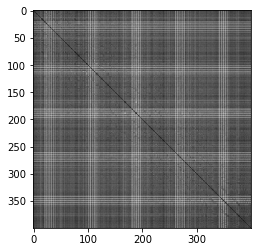

In [214]:
plt.imshow(cosine_matrix, cmap='gray')

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\collections.py:153: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


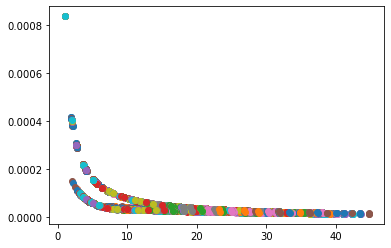

In [222]:
T, S = cir_profile_ld.shape
cir_noise = []

x_pre = []
for j in range(T):
    cir_t = [] # channel impulse response for a transmitter
    for i in range(S):
        c_tmp = cir_profile_ld[j, i].copy()
        c_tmp[0, :] = c_tmp[0, :] * 10 ** 7 # normalize the delay seconds
        
        m, n = c_tmp.shape
        if m == 2:
            c_tmp[1, :] = abs(c_tmp[1, :])
        
        # cir_normal.
        c_tmp_noise = noise_gen(c_tmp[1,:], 5)
        cir_noise.append(c_tmp_noise)
        plt.scatter(c_tmp[0, :], c_tmp[1, :])

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is sepa

<StemContainer object of 3 artists>

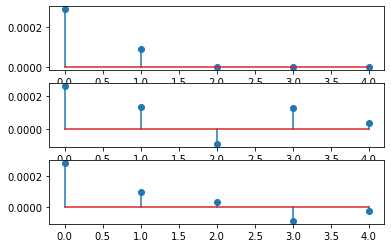

In [28]:
fig, axs = plt.subplots(3,1)
axs[0].stem(cir_normal[0])
axs[1].stem(cir_noise[0])
axs[2].stem(cir_noise_10[0])

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

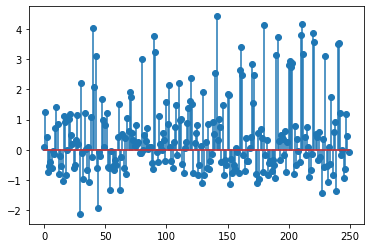

In [219]:
plt.stem(x_noise)

In [9]:
cir_array = np.array(cir_noise)
cir_normal_array = np.array(cir_normal)
cir_noise_10_array = np.array(cir_noise_10)

In [10]:
new_cir = cir_array.reshape(T, -1)
new_cir_normal = cir_normal_array.reshape(T, -1)
new_cir_10 = cir_noise_10_array.reshape(T, -1)

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection in

<StemContainer object of 3 artists>

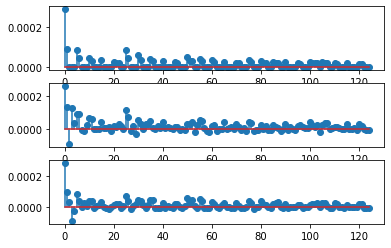

In [31]:
fig, axs = plt.subplots(3,1)
axs[0].stem(new_cir_normal[0], label='raw')
axs[1].stem(new_cir[0])
axs[2].stem(new_cir_10[0])

### Cosine similarity

In [11]:
dist_matrix_cos_10 = np.exp(-distance.cdist(new_cir, new_cir_10, 'cosine'))

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\spatial\distance.py:184: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.ascontiguousarray(X, dtype=out_type)


In [12]:
dist_matrix_cir_normal = np.exp(-distance.cdist(new_cir_normal, new_cir_normal, 'cosine'))

In [13]:
dist_matrix_cos_1010 = np.exp(-distance.cdist(new_cir_10, new_cir_10, 'cosine'))

In [14]:
dist_matrix_cos = np.exp(-distance.cdist(new_cir, new_cir, 'cosine'))

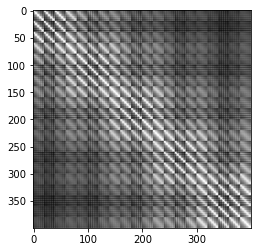

In [15]:
plt.imshow(dist_matrix_cir_normal, cmap='gray')

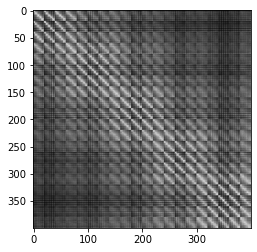

In [16]:
plt.imshow(dist_matrix_cos_10,cmap='gray')

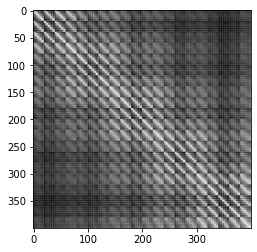

In [17]:
plt.imshow(dist_matrix_cos_1010,cmap='gray')

In [215]:
ind = np.random.randint(T)
ind = 108

In [216]:
def find_max(img):
    x, y = np.unravel_index(np.argmax(img, axis=None),np.shape(img))
    return  x, y

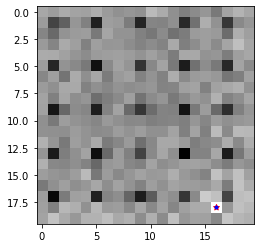

In [238]:
ind = np.random.randint(T)
mask = np.zeros((20, 20))
i, j = ind//20, ind%20
mask[i, j] = 10
# plt.imshow(ind//20, ind%20)
# fig, ax = plt.subplots()
img = np.exp(-cosine_matrix[ind, :]).reshape(20, 20)
x_cos, y_cos = find_max(img)
plt.imshow(img, cmap='gray')
plt.scatter(j, i, c='red', marker='*')
plt.scatter(y_cos, x_cos, c='b', marker='.')

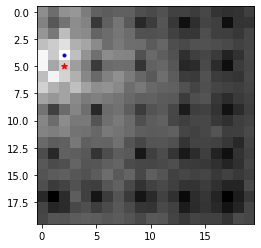

In [21]:
ind = np.random.randint(T)
mask = np.zeros((20, 20))
i, j = ind//20, ind%20
mask[i, j] = 10
# plt.imshow(ind//20, ind%20)
# fig, ax = plt.subplots()
img = dist_matrix_cos_10[ind, :].reshape(20, 20)
x_cos, y_cos = find_max(img)
plt.imshow(img, cmap='gray')
plt.scatter(j, i, c='red', marker='*')
plt.scatter(y_cos, x_cos, c='b', marker='.')

In [22]:
coord_ls_cos = []
dist_ls_cos = []

for i in range(len(dist_matrix_cos_10)):
    img = np.reshape(dist_matrix_cos_10[i, :], (20,20))
    x_tmp, y_tmp = find_max(img)
    ind_x, ind_y = i//20, i%20
    dist_ls_cos.append(50 * np.linalg.norm([x_tmp - ind_x, y_tmp - ind_y]))


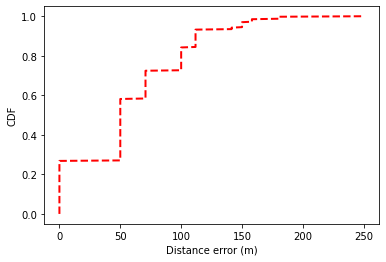

In [23]:
n = len(dist_ls_cos)
x = np.arange(n) / (n-1)
y = np.sort(dist_ls_cos)
plt.xlabel('Distance error (m)')
plt.ylabel('CDF')
plt.plot(y, x, '--', linewidth=2, color='r')

### XGBoost

In [32]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.pipeline import Pipeline
import seaborn as sns
import lightgbm as lgb
import itertools
import warnings


In [34]:
warnings.filterwarnings('ignore')

In [25]:
xgb_pipe = Pipeline([('scale', StandardScaler()), \
    ('xgb', xgb.XGBRegressor(n_estimators=500, eta=0.1, subsample=1, colsample_bytree=1, reg_lambda=0))])

In [26]:
train_set = []
label = []
for i in range(len(new_cir)):
    for j in range(i, len(new_cir)):
        train_set.append(np.concatenate([new_cir[i], new_cir[j]]))
        label.append(np.exp(-distance.cosine(new_cir[i], new_cir[j])))

In [27]:
train_set = np.array(train_set).astype(float)
label= np.array(label).astype(float)

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


In [28]:
all_train = list(itertools.combinations(new_cir,2))

In [29]:
cir_train = np.array(all_train).reshape(79800, 250).astype(float)

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


In [30]:
dist_train = dist_matrix_cos[np.triu_indices_from(dist_matrix_cos, k=1)]

In [31]:
xgb_pipe.fit(train_set, label)

Pipeline(steps=[('scale', StandardScaler()),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              eta=0.1, gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.100000001, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=500,
                              n_jobs=12, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=0, reg_lambda=0,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [411]:
s1 = np.concatenate([new_cir_10[ind], new_cir[0]]).astype(float).reshape(1, -1)
s2 = np.concatenate([new_cir_10[ind], new_cir[ind]]).astype(float).reshape(1, -1)

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [117]:
xgb_pipe.predict(tmp.astype(float))

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


array([0.775791], dtype=float32)

In [327]:
pdf = []
for i in new_cir:
    tmp = np.concatenate([i, new_cir_10[ind]]).reshape(1, -1)
    s = xgb_pipe.predict(tmp.astype(float))
    pdf.append(s)

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from 

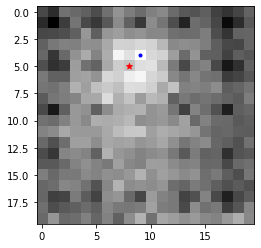

In [328]:
ind = 108
xgb_heat = np.array(pdf).reshape(20, 20)
i, j = ind//20, ind%20
x, y = np.unravel_index(np.argmax(xgb_heat, axis=None), xgb_heat.shape)
plt.imshow(xgb_heat, cmap='gray')
plt.scatter(j, i, c='red', marker='*')
plt.scatter(y, x, c='b', marker='.')

##### CDF for xgb method

In [35]:
from tqdm import tqdm

In [36]:
# pdf = []
dist_ls_xgb = []

for i in tqdm(range(len(new_cir))):
    s_ls = []
    for j in range(len(new_cir_10)):
        tmp = np.concatenate([new_cir[i], new_cir_10[j]]).reshape(1, -1)
        s = xgb_pipe.predict(tmp.astype(float))
        s_ls.append(s)
    img = np.reshape(s_ls, (20,20))
    x_xgb, y_xgb = i // 20, i % 20
    x_tmp, y_tmp = find_max(img)
    dist_ls_xgb.append(50 * np.linalg.norm([x_xgb-x_tmp, y_xgb-y_tmp]))
        # pdf.append(s)

100%|██████████| 400/400 [09:13<00:00,  1.38s/it]


399

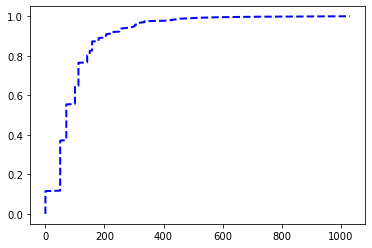

In [37]:
# n = len(data)
x = np.arange(n) / (n-1) 
y_xgb = np.sort(dist_ls_xgb)
# ax.set_xlabel('Distance error (m)')
# ax.set_y('CDF')
plt.plot(y_xgb, x, '--',label=label, linewidth=2, color='b')

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

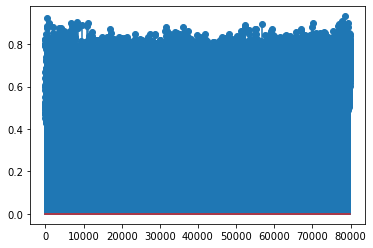

In [394]:
plt.stem(dist_train)

### Mahalanobis Distance

In [41]:
S = np.cov(new_cir.T)

In [74]:
ind = 108

In [71]:
inp = new_cir_10[ind]

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


In [111]:
pdf = []
d_ls = []
for i in new_cir:
    s = (inp - i).T @ np.linalg.inv(S) @ (inp - i)
    pdf.append(np.exp(-s.astype(float)))
    d_ls.append(s.astype(float))

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """
C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


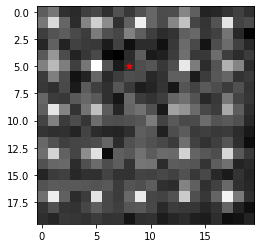

In [125]:
ma_heat = np.array(d_ls).reshape(20, 20)
i, j = ind//20, ind%20
plt.imshow(ma_heat, cmap='gray')
plt.scatter(j, i, c='red', marker='*')

In [243]:
from metric_learn import NCA, MMC, ITML, MLKR

### ITML

In [215]:
train_set_metric = []
train_set_mlkr = []
label_metric = []
for i in range(len(new_cir)):
    # for j in range(i, len(new_cir)):
    # train_set_mlkr.append((new_cir[i]-new_cir[j]).astype(float))
    train_set_metric.append(np.array([new_cir[i], new_cir[i]]))
    label_metric.append(1)
    train_set_metric.append(np.array([new_cir[i], new_cir[(i+200)%400]]))
    label_metric.append(-1)

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [173]:
train_set_metric = np.array(train_set_metric).astype(float)
# train_set_metric = np.transpose(train_set_metric, (0,2,1))

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


In [166]:
train_set_metric.shape, len(label_metric)
# train_set_metric[0]

((800, 125, 2), 800)

In [208]:
itml = ITML()

itml.fit(train_set_metric, label_metric)

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\metric_learn\itml.py:35: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X = np.vstack({tuple(row) for row in pairs.reshape(-1, pairs.shape[2])})
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\metric_learn\itml.py:66: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = min(_lambda[i], gamma_proj * (1. / wtw - 1. / pos_bhat[i]))


ITML()

In [ ]:
mahal = itml.get_mahalanobis_matrix()

#### MLKR

In [ ]:
train_set_mlkr = []
label_mlkr = []
for i in range(len(new_cir)):
    for j in range(i, len(new_cir)):
        train_set_mlkr.append(np.concatenate([new_cir[i], new_cir[j]]).astype(float))
        label_mlkr.append(distance.cosine(new_cir[i], new_cir[j]))

In [280]:
mlkr = MLKR()
indices = np.random.choice(len(label_mlkr),size=8000)
mlkr.fit(np.array(train_set_mlkr)[indices], np.array(label_mlkr)[indices])

MLKR()

In [281]:
mahal_mlkr = mlkr.get_mahalanobis_matrix()

In [210]:
score_ls = []

for i in new_cir:
    score = (new_cir_10[ind]-i).T @ mahal @ (new_cir_10[ind]-i)
    score_ls.append(np.exp(-score))

In [309]:
score_ls_mlkr = []

for i in new_cir:
    # score_mlkr = (new_cir_10[ind]-i).T @ mahal_mlkr @ (new_cir_10[ind]-i)
    v = np.concatenate([new_cir_10[ind], i])
    score_ls_mlkr.append(np.linalg.norm(v.T @ mahal_mlkr, 2))

In [235]:
mlkr.transform(new_cir[0].astype(float).reshape(1,-1)).shape

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  """Entry point for launching an IPython kernel.


(1, 125)

In [304]:
np.shape(score_ls_mlkr)


(5, 5)

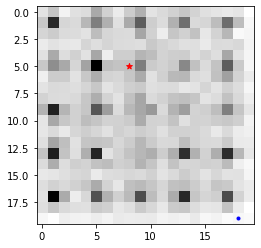

In [310]:
maha_heat = np.array(score_ls_mlkr).astype(float).reshape(20, 20)
i, j = ind//20, ind%20
x, y = find_max(-maha_heat)
plt.imshow(np.exp(-maha_heat), cmap='gray')
plt.scatter(j, i, c='red', marker='*')
plt.scatter(x, y, c='b', marker='.')